<a href="https://colab.research.google.com/github/chamisfum/LSTM_Bidirectional_LSTM_Doc_Classification/blob/master/Document_classification_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Define kaggle json path
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/RESEARCH CENTER/DATASETS"

In [ ]:
%cd /content/drive/My Drive/RESEARCH CENTER/DATASETS

/content/drive/My Drive/RESEARCH CENTER/DATASETS


In [ ]:
cd bbc_document_classification/

/content/drive/My Drive/RESEARCH CENTER/DATASETS/bbc_document_classification


In [ ]:
!ls # 

bbc  dev.csv  Document_classification.ipynb  test.csv  train.csv


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from bs4 import BeautifulSoup
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

### **Data preparation**

In [ ]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')

In [ ]:
data = pd.concat([df1,df2,df3]).drop_duplicates().reset_index(drop=True).drop(columns=['Unnamed: 0']).rename(columns={"text": "news_text"})

In [ ]:
data

,label,news_text
0,sport,Man Utd stroll to Cup win Wayne Rooney made a...
1,entertainment,Slater to star in Broadway play Actor Christi...
2,entertainment,US TV host Clark suffers stroke Veteran US te...
3,entertainment,"U2's desire to be number one U2, who have won..."
4,tech,Security warning over 'FBI virus' The US Fede...
...,...,...
2220,business,Kraft cuts snack ads for children Kraft plans...
2221,business,FBI agent colludes with analyst A former FBI ...
2222,politics,Defiant hunts put ban to the test Thousands o...
2223,business,Chinese exports rise 25% in 2004 Exports from...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      2225 non-null   object
 1   news_text  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### **Class distribution**

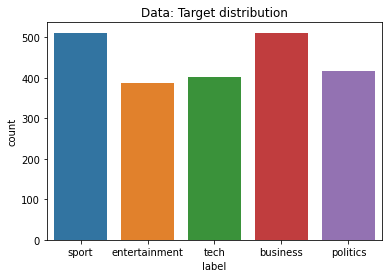

In [ ]:
sns.countplot(data['label']);
plt.title('Data: Target distribution');

In [ ]:
data.label.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

### **Data preview**

In [ ]:
def print_plot(index):
    example = data[data.index == index][['news_text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('label:', example[1])

In [ ]:
for i in range(0,50,3):
  print_plot(i)

Man Utd stroll to Cup win  Wayne Rooney made a winning return to Everton as Manchester United cruised into the FA Cup quarter-finals.  Rooney received a hostile reception, but goals in each half from Quinton Fortune and Cristiano Ronaldo silenced the jeers at Goodison Park. Fortune headed home after 23 minutes before Ronaldo scored when Nigel Martyn parried Paul Scholes' free-kick. Marcus Bent missed Everton's best chance when Roy Carroll, who was later struck by a missile, saved at his feet.  Rooney's return was always going to be a potential flashpoint, and he was involved in an angry exchange with a spectator even before kick-off. And Rooney's every touch was met with a deafening chorus of jeers from the crowd that once idolised the 19-year-old. Everton started brightly and Fortune needed to be alert to scramble away a header from Bent near the goal-line. But that was the cue for United to take complete control with a supreme passing display on a Goodison Park pitch that was cutting

### **Cleansing data Panctuation etc.**

Pemrosesan awal teks akan mencakup langkah-langkah berikut:
* Ubah semua teks menjadi huruf kecil.
* Ganti simbol REPLACE_BY_SPACE_RE dengan spasi dalam teks.
* Hapus simbol yang ada di BAD_SYMBOLS_RE dari teks.
* Hapus kata berhenti.
* Hapus angka dalam teks.

In [ ]:
df = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['news_text'] = df['news_text'].apply(clean_text)

In [ ]:
df['news_text'] = df['news_text'].str.replace('\d+', '')

In [ ]:
def print_plot(index):
    example = df[df.index == index][['news_text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('label:', example[1])

In [ ]:
for i in range(0,50,3):
  print_plot(i)

man utd stroll cup win wayne rooney made winning return everton manchester united cruised fa cup quarterfinals rooney received hostile reception goals half quinton fortune cristiano ronaldo silenced jeers goodison park fortune headed home  minutes ronaldo scored nigel martyn parried paul scholes freekick marcus bent missed evertons best chance roy carroll later struck missile saved feet rooneys return always going potential flashpoint involved angry exchange spectator even kickoff rooneys every touch met deafening chorus jeers crowd idolised yearold everton started brightly fortune needed alert scramble away header bent near goalline cue united take complete control supreme passing display goodison park pitch cutting fortune gave united lead  minutes rising meet ronaldos cross eight yards portuguese youngster allowed much time space hapless gary naysmith united dominated without creating many clearcut chances almost paid price making domination two minutes halftime mikel arteta played 

### **LSTM Modeling**

* Vektorisasi teks keluhan konsumen, dengan mengubah setiap teks menjadi urutan bilangan bulat atau vektor.
* Batasi kumpulan data hingga 5.0000 kata teratas.
* Atur jumlah kata maksimal di setiap keluhan menjadi 250.

In [ ]:
df['count'] = df['news_text'].str.findall(r'(\w+)').str.len()
df.describe()

,count
count,2225.000000
mean,217.544270
std,125.838515
min,48.000000
25%,141.000000
50%,190.000000
75%,268.000000
max,2216.000000


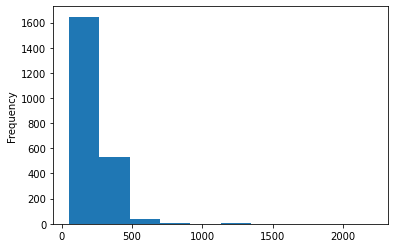

In [ ]:
df['count'].plot(kind='hist')

In [ ]:
df = df.drop(columns="count")

### **Tokenizer definition**

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 600
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['news_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31363 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['news_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2225, 600)


In [ ]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2225, 5)


### **Splitting dataset**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1780, 600) (1780, 5)
(445, 600) (445, 5)


### **Build model**

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

### **EarlyStopping**

In [ ]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0.0001,
                   patience=3,
                   verbose=1,
                   mode="auto",
                   baseline=None,
                   restore_best_weights=True,
                   )

In [ ]:
import time
start_time = time.time() 
history = model.fit(X_train, Y_train, 
                    epochs=50, batch_size=64,
                    steps_per_epoch=16,
                    validation_data=(X_test, Y_test),
                    callbacks=es)

end_time = time.time() 

Epoch 1/50
16/16 [==============================] - 35s 2s/step - loss: 1.6007 - accuracy: 0.2461 - val_loss: 1.5981 - val_accuracy: 0.2382
Epoch 2/50
16/16 [==============================] - 35s 2s/step - loss: 1.5708 - accuracy: 0.2757 - val_loss: 1.5916 - val_accuracy: 0.2427
Epoch 3/50
16/16 [==============================] - 36s 2s/step - loss: 1.4622 - accuracy: 0.3545 - val_loss: 1.5777 - val_accuracy: 0.2539
Epoch 4/50
16/16 [==============================] - 36s 2s/step - loss: 1.3449 - accuracy: 0.4318 - val_loss: 1.5164 - val_accuracy: 0.4629
Epoch 5/50
16/16 [==============================] - 36s 2s/step - loss: 1.0783 - accuracy: 0.5635 - val_loss: 1.3689 - val_accuracy: 0.6202
Epoch 6/50
16/16 [==============================] - 36s 2s/step - loss: 0.9773 - accuracy: 0.5968 - val_loss: 0.9996 - val_accuracy: 0.5640
Epoch 7/50
16/16 [==============================] - 35s 2s/step - loss: 0.8533 - accuracy: 0.6690 - val_loss: 1.0081 - val_accuracy: 0.6876
Epoch 8/50
16/16 [==

### **Model training time**

In [ ]:
print("Running time : ", end_time - start_time)

Running time :  831.2980365753174


In [ ]:
from sklearn import metrics
from sklearn.metrics import  precision_recall_curve, f1_score, multilabel_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import label_ranking_average_precision_score, coverage_error
from sklearn.metrics import label_ranking_loss

### **Accuracy and Loss**

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Validation set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 2s 137ms/step - loss: 0.3192 - accuracy: 0.9101
Validation set
  Loss: 0.319
  Accuracy: 0.910


In [ ]:
accr = model.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

56/56 [==============================] - 9s 155ms/step - loss: 0.0778 - accuracy: 0.9983
Train set
  Loss: 0.078
  Accuracy: 0.998


In [ ]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

### **Precision rangking score**

In [ ]:
label_ranking_average_precision_score(Y_test, test_pred)

0.9476029962546815

In [ ]:
label_ranking_average_precision_score(Y_train, train_pred)

0.9991573033707866

### **Label rangking loss**

In [ ]:
label_ranking_loss(Y_test, test_pred)

0.03651685393258427

In [ ]:
label_ranking_loss(Y_train, train_pred)

0.0004213483146067416

### **Baseline graph**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

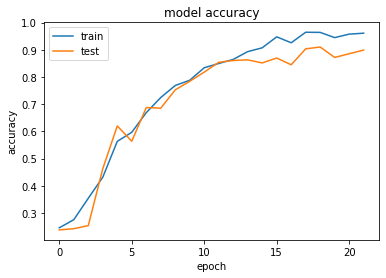

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

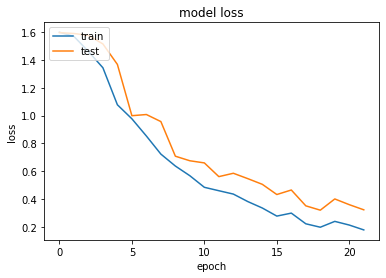

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()